# Autonomous Driving - Car Detection

**GOAL**:
- Detect objects in a car detection dataset
- Implement non-max suppression to increase accuracy
- Handle bounding boxes around detected objects

**Algorithm Used**:
YOLO algorithm with Drive.ai car detection dataset. 
Please refer: [Redmon et al., 2016](https://arxiv.org/abs/1506.02640) and [Redmon and Farhadi, 2016](https://arxiv.org/abs/1612.08242). 

## Table of Contents

- [Packages](#0)
- [1 - Car Dataset](#1)
- [2 - YOLO](#2)
    - [2.1 - Model Details](#2-1)
    - [2.2 - Non-max Suppression](#2-2)
    - [2.3 - YOLO Non-max Suppression](#2-3)
- [3 - Test YOLO Pre-trained Model on Images](#3)
    - [3.1 - Defining Classes, Anchors and Image Shape](#3-1)
    - [3.2 - Run the YOLO on an Image](#3-2)
- [4 - Summary for YOLO](#4)

<a name='0'></a>
## Packages

In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [2]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image

%matplotlib inline

C:\Users\saura\AppData\Local\Temp\ipykernel_23536\1613439058.py:6: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  import scipy.misc


<a name='1'></a>
## 1 - Car Dataset

The Drive.ai Sample Dataset is utilized as the sample data in this project. To collect data for this dataset, a camera was mounted on the hood of a car, capturing images of the road ahead every few seconds during driving sessions.​

<center>
<video width="400" height="200" src="nb_images/road_video_compressed2.mp4" type="video/mp4" controls>
</video>
</center>

<caption><center> Pictures taken from a car-mounted camera while driving around Silicon Valley. <br> Dataset provided by <a href="https://www.drive.ai/">drive.ai</a>.
</center></caption>

These images have been labelled by drawing bounding boxes around every car found:

<center>
<img src="nb_images/box_label.png" style="width:500px;height:250;">
</center>
<caption><center><u><b>Figure 1</u></b></center></caption>

If there are 80 classes for the object detector to recognize, the class label $c$ can be represented either as an integer from 1 to 80 or as an 80-dimensional one-hot vector—where one component is 1 and the rest are 0.

In this project, the YOLO ("You Only Look Once") model is utilized for object detection and applied to car detection. Since training the YOLO model is computationally intensive, pre-trained weights are loaded to facilitate immediate use.

<a name='2'></a>
## 2 - YOLO

"You Only Look Once" (YOLO) is a popular algorithm because it achieves high accuracy while also being able to run in real time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

<a name='2-1'></a>
### 2.1 - Model Details

#### Inputs and outputs
- The **input** is a batch of images, and each image has the shape (608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If you expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

#### Anchor Boxes
* Anchor boxes are chosen by exploring the training data to choose reasonable height/width ratios that represent the different classes.  For this assignment, 5 anchor boxes were chosen for you (to cover the 80 classes), and stored in the file './model_data/yolo_anchors.txt'
* The dimension of the encoding tensor of the second to last dimension based on the anchor boxes is $(m, n_H,n_W,anchors,classes)$.
* The YOLO architecture is: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).  


#### Encoding
<img src="nb_images/architecture.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: Encoding architecture for YOLO<br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since you're using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, last two dimensions of the shape (19, 19, 5, 85) are flattened, so the output of the Deep CNN is (19, 19, 425).

<img src="nb_images/flatten.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 3 </u></b>: Flattening the last two last dimensions<br> </center></caption>

#### Class score

Now, for each box (of each cell) you'll compute the following element-wise product and extract a probability that the box contains a certain class.  
The class score is $score_{c,i} = p_{c} \times c_{i}$: the probability that there is an object $p_{c}$ times the probability that the object is a certain class $c_{i}$.

<img src="nb_images/probability_extraction.png" style="width:700px;height:400;">
<caption><center> <u><b>Figure 4</u></b>: Find the class detected by each box<br> </center></caption>

##### Example of figure 4
* In figure 4, let's say for box 1 (cell 1), the probability that an object exists is $p_{1}=0.60$.  So there's a 60% chance that an object exists in box 1 (cell 1).  
* The probability that the object is the class "category 3 (a car)" is $c_{3}=0.73$.  
* The score for box 1 and for category "3" is $score_{1,3}=0.60 \times 0.73 = 0.44$.  
* Let's say you calculate the score for all 80 classes in box 1, and find that the score for the car class (class 3) is the maximum.  So you'll assign the score 0.44 and class "3" to this box "1".

#### Visualizing classes
Here's one way to visualize what YOLO is predicting on an image:

- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across the 80 classes, one maximum for each of the 5 anchor boxes).
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<img src="nb_images/proba_map.png" style="width:300px;height:300;">
<caption><center> <u><b>Figure 5</u></b>: Each one of the 19x19 grid cells is colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Note that this visualization isn't a core part of the YOLO algorithm itself for making predictions; it's just a nice way of visualizing an intermediate result of the algorithm. 

#### Visualizing bounding boxes
Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="nb_images/anchor_map.png" style="width:200px;height:200;">
<caption><center> <u><b>Figure 6</u></b>: Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

#### Non-Max suppression
In the figure above, the only boxes plotted are ones for which the model had assigned a high probability, but this is still too many boxes. You'd like to reduce the algorithm's output to a much smaller number of detected objects.  

To do so, you'll use **non-max suppression**. Specifically, you'll carry out these steps: 
- Get rid of boxes with a low score. Meaning, the box is not very confident about detecting a class, either due to the low probability of any object, or low probability of this particular class.
- Select only one box when several boxes overlap with each other and detect the same object.

In [3]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = .6):
    """
    Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes: tensor of shape (19, 19, 5, 4)
        box_confidence: tensor of shape (19, 19, 5, 1)
        box_class_probs: tensor of shape (19, 19, 5, 80)
        threshold: real value, if [ highest class probability score < threshold], then get rid of the corresponding box

    Returns:
        scores: tensor of shape (None,), containing the class probability score for selected boxes
        boxes: tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes: tensor of shape (None,), containing the index of the class detected by the selected boxes
    """
    box_scores = box_class_probs * box_confidence
    box_classes = tf.math.argmax(box_scores,axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores,axis=-1)
    
    # Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    filtering_mask = (box_class_scores >= threshold)
    
    # Apply the mask to box_class_scores, boxes and box_classes
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    
    return scores, boxes, classes

<a name='2-3'></a>
### 2.2 - Non-max Suppression

Even after filtering by thresholding over the class scores, you still end up with a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

<img src="nb_images/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <u> <b>Figure 7</b> </u>: In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probability) of the 3 boxes. <br> </center></caption>


Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<center><img src="nb_images/iou.png" style="width:500px;height:400;"></center>
<caption><center> <u> <b>Figure 8</b> </u>: Definition of "Intersection over Union". <br> </center></caption>

- To find the **intersection** of the two boxes $(xi_{1}, yi_{1}, xi_{2}, yi_{2})$: 
    - Feel free to draw some examples on paper to clarify this conceptually.
    - The top left corner of the intersection $(xi_{1}, yi_{1})$ is found by comparing the top left corners $(x_1, y_1)$ of the two boxes and finding a vertex that has an x-coordinate that is closer to the right, and y-coordinate that is closer to the bottom.
    - The bottom right corner of the intersection $(xi_{2}, yi_{2})$ is found by comparing the bottom right corners $(x_2,y_2)$ of the two boxes and finding a vertex whose x-coordinate is closer to the left, and the y-coordinate that is closer to the top.
    - The two boxes **may have no intersection**.  You can detect this if the intersection coordinates you calculate end up being the top right and/or bottom left corners of an intersection box.  Another way to think of this is if you calculate the height $(y_2 - y_1)$ or width $(x_2 - x_1)$ and find that at least one of these lengths is negative, then there is no intersection (intersection area is zero).  
    - The two boxes may intersect at the **edges or vertices**, in which case the intersection area is still zero.  This happens when either the height or width (or both) of the calculated intersection is zero.

In [4]:
def iou(box1, box2):
    """
    Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1: first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2: second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    xi1 = max(box1_x1,box2_x1)
    yi1 = max(box1_y1,box2_y1)
    xi2 = min(box1_x2,box2_x2)
    yi2 = min(box1_y2,box2_y2)
    inter_width = max(0,yi2 - yi1)
    inter_height =  max(0,xi2 - xi1)
    inter_area = inter_width*inter_height
    
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    box1_area = (box1_x2-box1_x1)*((box1_y2-box1_y1))
    box2_area = (box2_x2-box2_x1)*((box2_y2-box2_y1))
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    iou = inter_area/union_area
    
    return iou

<a name='2-4'></a>
### 2.3 - YOLO Non-max Suppression

The key steps are: 
1. Select the box that has the highest score.
2. Compute the overlap of this box with all other boxes, and remove boxes that overlap significantly (iou >= `iou_threshold`).
3. Go back to step 1 and iterate until there are no more boxes with a lower score than the currently selected box.

This will remove all boxes that have a large overlap with the selected boxes. Only the "best" boxes remain.

In [5]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores: tensor of shape (None,), output of yolo_filter_boxes()
    boxes: tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes: tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes: integer, maximum number of predicted boxes you'd like
    iou_threshold: real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores: tensor of shape (None, ), predicted score for each box
    boxes: tensor of shape (None, 4), predicted box coordinates
    classes: tensor of shape (None, ), predicted class for each box
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold)
    scores = tf.gather(scores,nms_indices)
    boxes = tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)
    
    return scores, boxes, classes

In [6]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


In [7]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs:   output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape: tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes: integer, maximum number of predicted boxes you'd like
    score_threshold: real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold: real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores: tensor of shape (None, ), predicted score for each box
    boxes: tensor of shape (None, 4), predicted box coordinates
    classes:  tensor of shape (None,), predicted class for each box
    """
    
    # Retrieve outputs of the YOLO model
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    
    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    
    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)
    
    # Perform Non-max suppression with maximum number of boxes set to max_boxes and a threshold of iou_threshold
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

<a name='3'></a>
## 3 - Test YOLO Model on Images

<a name='3-1'></a>
### 3.1 - Defining Classes, Anchors and Image Shape

- The information on the 80 classes and 5 boxes is gathered in two files: "coco_classes.txt" and "yolo_anchors.txt". 
- The car detection dataset has 720x1280 images, which are pre-processed into 608x608 images.

In [8]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

In [9]:
yolo_model = load_model("model_data/", compile=False)

In [10]:
yolo_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

<a name='3-3'></a>
### 3.2 - Convert Output of the Model to Usable Bounding Box Tensors

The output of `yolo_model` is a (m, 19, 19, 5, 85) tensor that needs to pass through non-trivial processing and conversion. Call `yolo_head` to format the encoding of the model into something decipherable:

```
yolo_model_outputs = yolo_model(image_data) 
yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
```

The variable `yolo_outputs` will be defined as a set of 4 tensors that you can then use as input by your yolo_eval function.

<a name='3-5'></a>
### 3.2 - Run the YOLO on an Image

This will create a graph that can be summarized as follows:

- `yolo_model.input` is given to `yolo_model`. The model is used to compute the output `yolo_model.output`
- `yolo_model.output` is processed by `yolo_head`. It gives you `yolo_outputs`
- `yolo_outputs` goes through a filtering function, `yolo_eval`. It outputs your predictions: `out_scores`, `out_boxes`, `out_classes`.

In [11]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file: name of an image stored in the "images" folder.
    
    Returns:
    out_scores: tensor of shape (None, ), scores of the predicted boxes
    out_boxes: tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes: tensor of shape (None, ), class index of the predicted boxes    
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data)
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", image_file))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

Run the following cell on the "test.jpg" image to verify that your function is correct.

Found 10 boxes for images/chicago2.jpg
car 0.69 (787, 737) (1113, 960)
car 0.58 (509, 826) (1024, 1191)
bus 0.55 (1323, 517) (1832, 1018)
car 0.54 (38, 800) (533, 1109)
traffic light 0.54 (745, 588) (780, 655)
car 0.50 (1043, 740) (1215, 928)
traffic light 0.50 (2005, 308) (2048, 470)
car 0.45 (465, 788) (730, 925)
traffic light 0.41 (354, 467) (400, 555)
traffic light 0.41 (1558, 351) (1594, 428)


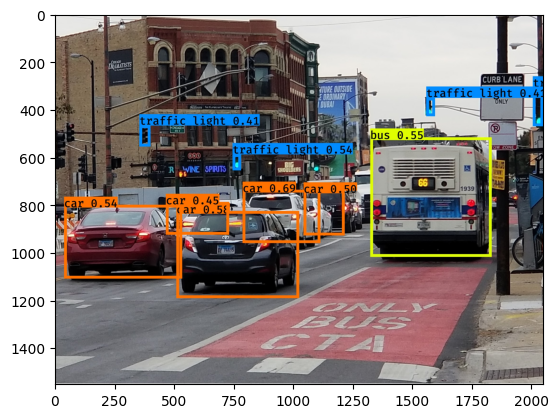

In [13]:
out_scores, out_boxes, out_classes = predict("chicago2.jpg")

This model is able to detect 80 different classes listed in "coco_classes.txt". To test the model on other images:
1. Add any image to this Jupyter Notebook's directory, in the "images" folder
2. Write your image's name in the cell above code
3. Run the code and see the output of the algorithm!


<a name='4'></a>
## 4 - Summary for YOLO

- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and 80 is the number of classes we'd like to detect
- You then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives you YOLO's final output. 